# Offline Analysis Kafka events

## Json to Dataframe

In [1]:
import pandas as pd   
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
kafka_events = []
for line in open('outputmod.json', 'r'):
    kafka_events.append(json.loads(line))

In [3]:
print("the number of events in this sample is : " + str(len(kafka_events)))

the number of events in this sample is : 127605


In [4]:
df_kafka_events = pd.DataFrame(kafka_events)

In [5]:
df_kafka_events.sort_values("timestamp", inplace=True)

In [6]:
df_kafka_events.head(10)

,eventType,uid,timestamp,ip,impressionId
0,display,27240866-b0c0-4227-8ebd-cc0d1dfbe99c,1591264812,223.135.140.156,e8364f11-71da-4da0-8d7f-dafa4ea44ffd
1,display,d6d11014-0c1c-4d46-b944-cf4a6d535d5510,1591264838,238.186.83.58,37e31030-9265-440a-96a4-4df853e16983
2,click,d6d11014-0c1c-4d46-b944-cf4a6d535d5510,1591264838,238.186.83.58,37e31030-9265-440a-96a4-4df853e16983
21,display,5df25e81-a3d8-4e73-acbf-29d64aef66e5,1591264839,219.184.147.61,3bda7969-dbfb-45ae-92b6-248a0a90444a
20,click,a4aaec8f-bd17-49e1-9d31-22276aab220119,1591264839,238.186.83.58,6d40b8d0-5a6a-4b6e-ad19-13b0e0ce1d30
19,display,a4aaec8f-bd17-49e1-9d31-22276aab220119,1591264839,238.186.83.58,6d40b8d0-5a6a-4b6e-ad19-13b0e0ce1d30
18,click,9f72ce96-abb8-4eb2-a395-104e6ed2c14218,1591264839,238.186.83.58,0da50736-ab32-4723-89fe-bf4d0fa8e955
17,display,9f72ce96-abb8-4eb2-a395-104e6ed2c14218,1591264839,238.186.83.58,0da50736-ab32-4723-89fe-bf4d0fa8e955
16,click,9ccc3c9e-81e9-4374-af7d-228118d0332817,1591264839,238.186.83.58,c3711b65-6d8f-4c93-a0dd-1a8743d58819
15,display,9ccc3c9e-81e9-4374-af7d-228118d0332817,1591264839,238.186.83.58,c3711b65-6d8f-4c93-a0dd-1a8743d58819


In [7]:
df_kafka_events['eventType'].value_counts()

display    96600
click      31005
Name: eventType, dtype: int64

# Nombre Display et Nombre d'id publicitaire

In [9]:
df_kafka_events['impressionId'].value_counts().max()

2

In [10]:
print('nombre impression',len(df_kafka_events['impressionId'].unique()))
print('nombre display',df_kafka_events['eventType'].value_counts()['display'])

nombre impression 96600
nombre display 96600


In [11]:
print('nombre moyen CTR', df_kafka_events['eventType'].value_counts()['click']/df_kafka_events['eventType'].value_counts()['display'])

nombre moyen CTR 0.32096273291925465


# Temps avant de cliquer

In [12]:
df_time=df_kafka_events.groupby(['uid','impressionId']).apply(lambda x: x['timestamp'].values)
df_time=pd.DataFrame(df_time)
df=df_time[0].apply(pd.Series)
df = df[df[1].notna()]
df['time_bef_click']=df[1]-df[0]
df_time_bef_click=df.groupby('uid')['time_bef_click'].agg([np.min, np.max, np.mean])

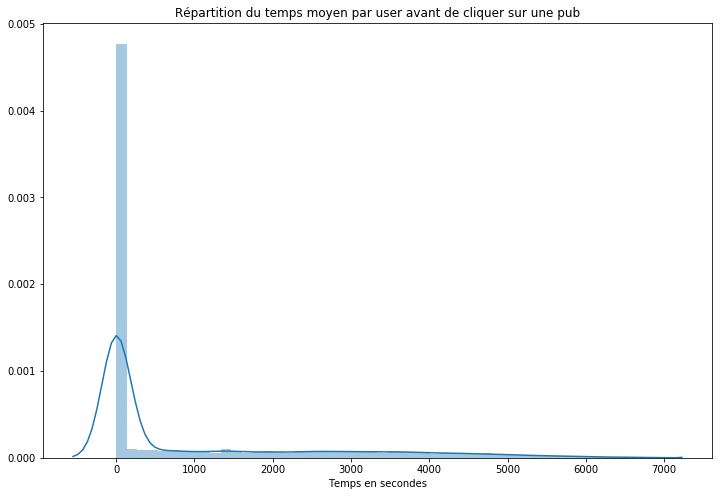

In [13]:
plt.figure(figsize = (12, 8))
sns.distplot(df_time_bef_click['mean'])
plt.title("Répartition du temps moyen par user avant de cliquer sur une pub")
plt.xlabel("Temps en secondes")
plt.show()

In [14]:
df_time=df_kafka_events.groupby(['ip','impressionId']).apply(lambda x: x['timestamp'].values)
df_time=pd.DataFrame(df_time)
df=df_time[0].apply(pd.Series)
df = df[df[1].notna()]
df['time_bef_click']=df[1]-df[0]
df_time_befcli_ip=df.groupby('ip')['time_bef_click'].agg([np.min, np.max, np.mean])

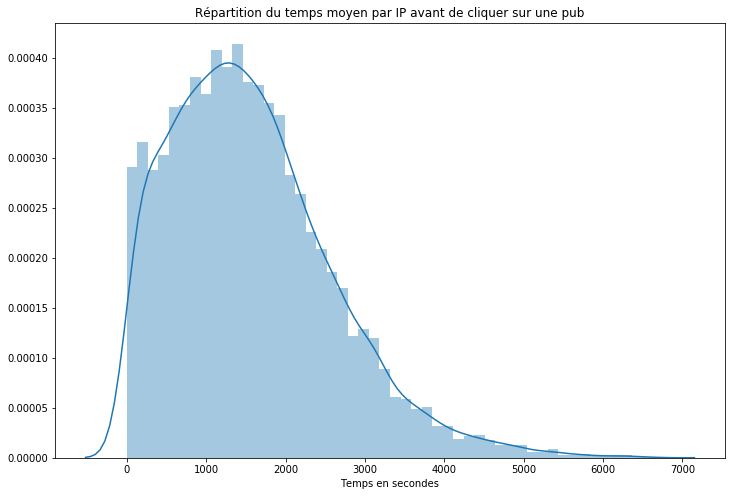

In [15]:
plt.figure(figsize = (12, 8))
sns.distplot(df_time_befcli_ip['mean'])
plt.title("Répartition du temps moyen par IP avant de cliquer sur une pub")
plt.xlabel("Temps en secondes")
plt.show()

# CTR

In [16]:
df_ratio=df_kafka_events.groupby(['uid']).eventType.value_counts().unstack(fill_value=0)
df_ratio['ratio']=df_ratio['click']/df_ratio['display']

In [21]:
np.min(df_ratio[df_ratio['click']>3]['ratio'])

0.4154200230149597

In [22]:
np.max(df_ratio[df_ratio['click']>3]['ratio'])

0.47675675675675677

In [23]:
df_ratio[df_ratio['click']==1]['ratio'].mean()

0.9853852021357744

In [24]:
np.histogram(df_ratio['ratio'])

(array([38867,     0,     0,    16,    50,   298,     1,     0,     0,
        10619], dtype=int64),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

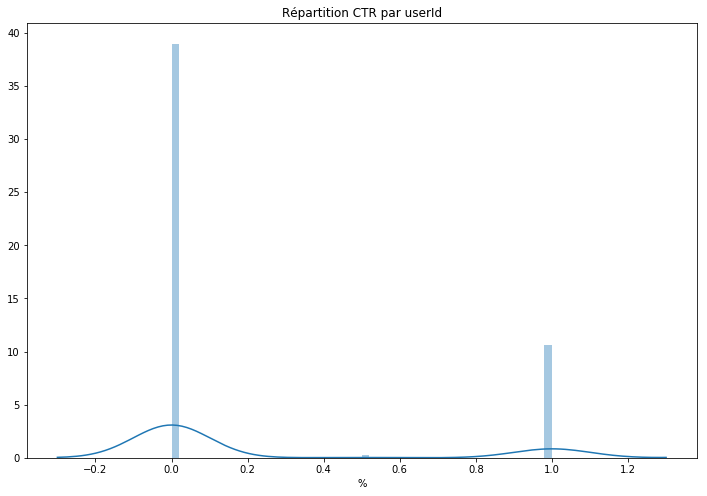

In [25]:
plt.figure(figsize = (12, 8))
sns.distplot(df_ratio['ratio'], kde_kws={'bw':0.1})
plt.title("Répartition CTR par userId")
plt.xlabel("%")
plt.show()

In [26]:
df_ratio2=df_kafka_events.groupby(['ip']).eventType.value_counts().unstack(fill_value=0)
df_ratio2['ratio']=df_ratio2['click']/df_ratio2['display']

In [27]:
np.histogram(df_ratio2['ratio'])

(array([1146, 2007, 3037, 1658, 1085,  826,  142,   66,   23,   10],
       dtype=int64),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

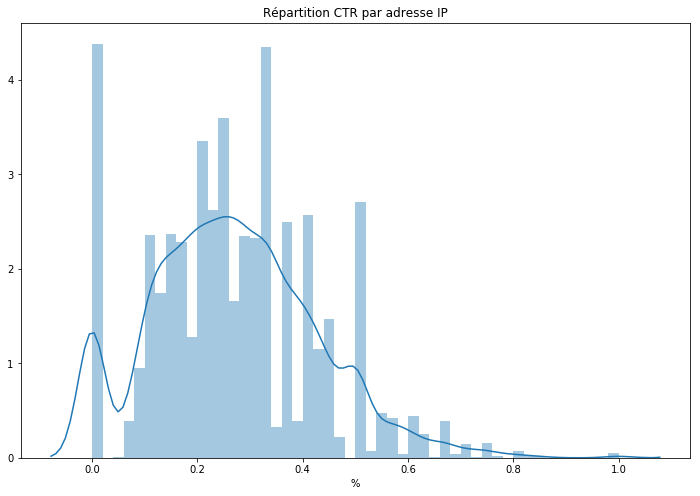

In [28]:
plt.figure(figsize = (12, 8))
sns.distplot(df_ratio2['ratio'])
plt.title("Répartition CTR par adresse IP")
plt.xlabel("%")
plt.show()